# Intercellular Context Factorization with MOFA

## Background

Here, we will adapt the statistical framework of multi-omics factor analysis ([MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124)) to obtain intercellular communication programmes - in the form of ligand-receptor interaction scores observed to change across samples. This application of MOFA is inspired by and is in line with the factorization proposed by Tensor-cell2cell [Armingol and Baghdassarian et al., 2022](https://www.nature.com/articles/s41467-022-31369-2) - see existing [tutorial](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html). 

Such factorization approaches essentially enable us to decipher context-driven intercellular communication by simultaneously accounting for an unlimited number of “contexts” in an untargeted manner.
Similarly to Tensor-cell2cell, this application of MOFA is able to handle cell-cell communication results coming from any experimental design, regardless of its complexity. 

Simply put, we will use LIANA’s output by sample to build a multi-view structure represented by samples and interactions by cell type pairs (views). 
We will then use [MOFA+](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1) to capture the CCC patterns across samples. To do so, we combine liana with the [MuData](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html)/[muon](https://link.springer.com/article/10.1186/s13059-021-02577-8) infrastructure.

## Load Packages

mofa, decoupler, and omnipath can be installed via pip with the following commands:

```python
pip install decoupler
pip install mofax
pip install muon
pip install omnipath
```

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

import decoupler as dc

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load & Prep Data

As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

In [2]:
adata = li.testing.datasets.kang_2018()

In [3]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [4]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_abbr'

### Basic Preparation

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [5]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

### Showcase the data

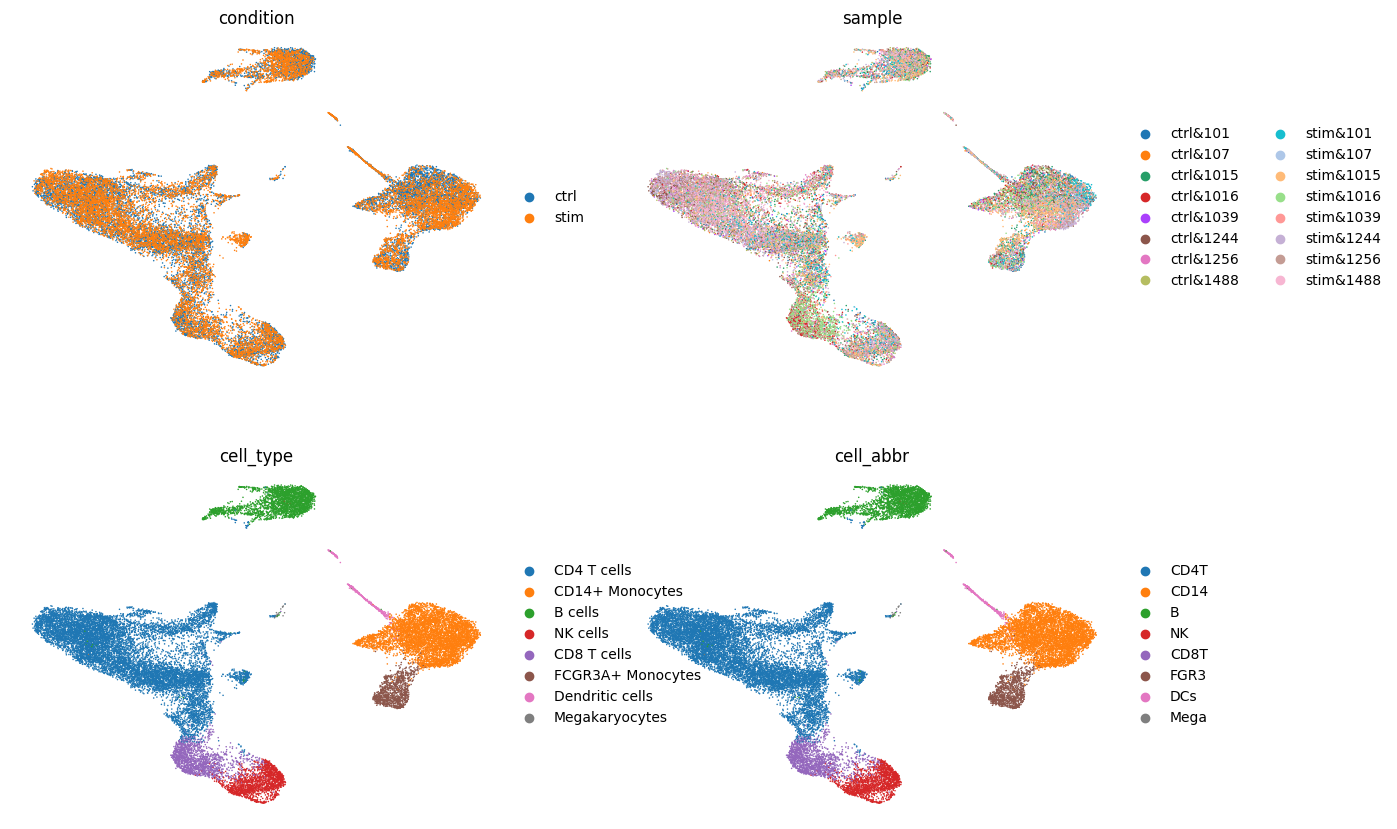

In [6]:
# Show pre-computed UMAP
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

## Ligand-Receptor Inference by Sample

Before we decompose the CCC patterns across contexts/samples with `MOFA`, we first need to run `liana` on each sample. To do so, liana provides a utility function called `by_sample` that runs each method in LIANA on each sample within the `AnnData` object, and returns a long-format `pandas.DataFrame` with the results.

In this example, we will use liana's `rank_aggregate` method, which provides a robust rank consensus that combines the predictions of multiple ligand-receptor methods. Nevertheless, any other method can be used.

In [7]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    sample_key=sample_key, # sample key by which we which to loop
    expr_prop = 0.1,
    use_raw=False, 
    n_perms=100, # reduce permutations for speed
    return_all_lrs=False, # we don't return all LR values to utilize MOFA's flexible views
    verbose=True, # use 'full' to show all information
    ) 

Now running: stim&1488: 100%|██████████| 16/16 [01:35<00:00,  6.00s/it]


Check results

In [8]:
adata.uns["liana_res"].sort_values("magnitude_rank").head()

,sample,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
18040,stim&1015,NK,CD8T,B2M,CD3D,2.483042,0.0,2.652776,1.086438,0.628031,0.077230,0.978141,0.119143,0.0,0.012823,4.430283e-09
6719,ctrl&1039,FGR3,CD14,TIMP1,CD63,2.547695,0.0,5.674415,1.301281,1.767435,0.104337,0.981838,0.246975,0.0,0.004135,4.913099e-09
26009,stim&1256,NK,CD8T,B2M,CD3D,2.655090,0.0,3.819609,1.123354,0.749565,0.085849,0.981475,0.144068,0.0,0.011988,6.091422e-09
1597,ctrl&107,FGR3,CD14,TIMP1,CD63,2.544711,0.0,5.852476,1.065290,1.678028,0.104096,0.982827,0.232994,0.0,0.001832,8.509626e-09
9014,ctrl&1244,FGR3,CD14,TIMP1,CD63,2.504210,0.0,5.661785,1.703509,2.209408,0.116978,0.985015,0.222247,0.0,0.001949,1.009959e-08


In [9]:
adata.uns["liana_res"]['source'].unique()

array(['FGR3', 'CD14', 'NK', 'CD8T', 'B', 'DCs', 'CD4T'], dtype=object)

<div class="alert alert-info">

**Note**
    
<h4> by_sample </h4>

We see that in addition to the usual results, we also get `sample` as a column which corresponds to the name of the `sample_key` in the `AnnData` object.

</div>  

Now that we have obtained results by sample, we can use a dotplot by sample to visualize the ligand-receptor interactions. Let's pick arbitrarily the interactions with the highest `magnitude_rank`.

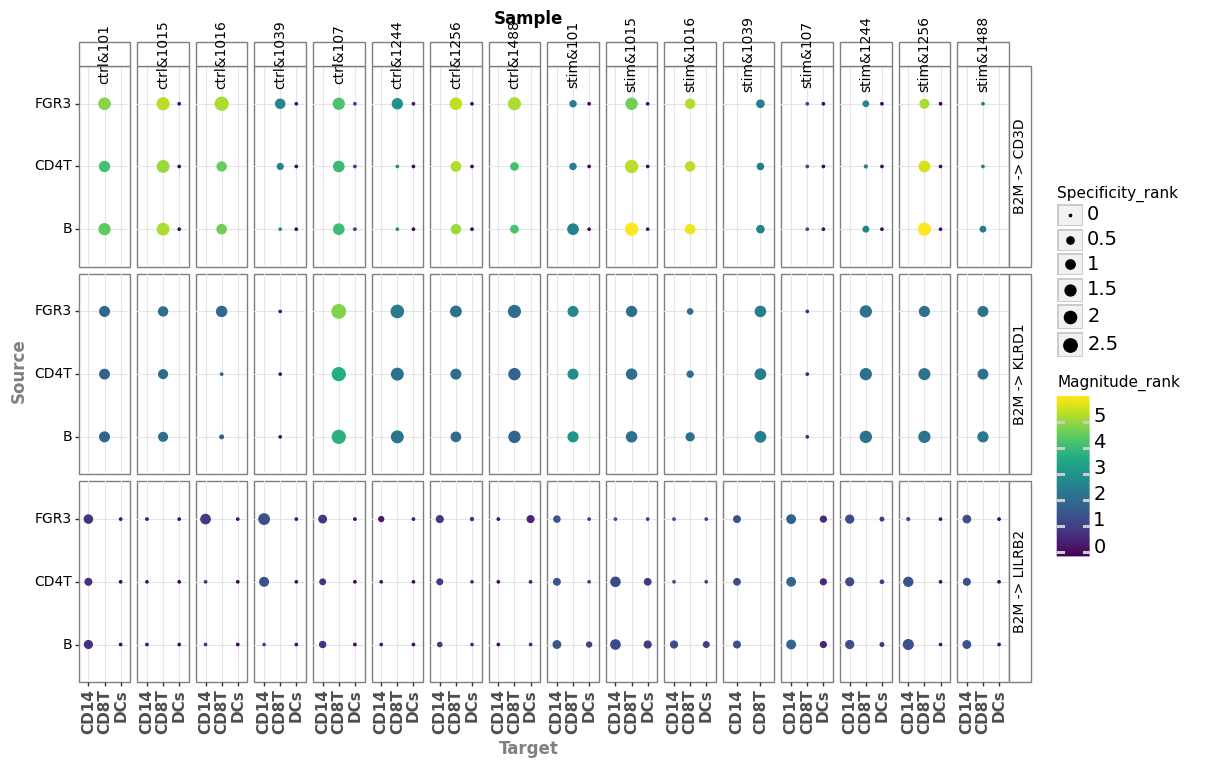

<ggplot: (8736183158427)>

In [10]:
(li.pl.dotplot_by_sample(adata, sample_key=sample_key,
                         colour="magnitude_rank", size="specificity_rank",
                         source_labels=["CD4T", "B", "FGR3"],
                         target_labels=["CD8T", 'DCs', 'CD14'],
                         ligand_complex=["B2M"],
                         inverse_colour=True,
                         inverse_size=True,
                         receptor_complex=["KLRD1", "LILRB2", "CD3D"],
                         figure_size=(12, 8),
                         size_range=(0.5, 5),
                         ) +
    # rotate facet labels
    p9.theme(strip_text=p9.element_text(size=10, colour="black", angle=90))
 )

Even on a small subset interactions and cell types, we can see that interpretation becomes challenging. To overcome this, we can use MOFA to find the variable CCC patterns across contexts/samples.

## Create a Multi-View Structure

Before we can identify the variable CCC patterns across contexts/samples, we need to create a multi-view structure. 
In this case, we will use the `lrs_to_views` function from liana to create a list of views (stored in a MuData object), where each view corresponds to a pair of potentially interacting cell types.
The scores of interactions between cell type pairs represent those inferred with liana, stored by default in `adata.uns['liana_res']`. Here, we will use liana's aggregate 'magnitude_rank'.

In [11]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              obs_keys=['patient', 'condition'], # add those to mdata.obs
                              lr_prop = 0.3, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 20, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 10, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 44/44 [00:00<00:00, 259.34it/s]


The `lr_fill` parameter controls how we deal with missing interaction scores. The default is `np.nan` and in that case the scores would be imputed by MOFA.

Here, we fill the missing ligand-receptors with 0s because the ligand-receptor interaction missing here, i.e. those when `return_all_lrs=False`, are such which are not expressed above a certain proportion of cells per cell type (that is controlled via `expr_prop` when running liana).

Given the assumption that the ligand-receptor interactions occur at the across cell type level, we could thus assume that the genes that are not present in a sufficient proportion of cells are unlikely to be involved in interactions that are relevant to the cell type as a whole.

<div class="alert alert-info">

**Note**
    
<h5> View Representation </h5>

MOFA supports the flexible representation of views, where each view can represent a different type of features (e.g. genes, proteins, metabolites, etc.). In this case, we simply allow for different ligand-receptor to be used in each cell type pair (view).

</div>  

In [12]:
mdata

MuData object with n_obs × n_vars = 16 × 1714
  obs:	'patient', 'condition'
  37 modalities
    FGR3&CD14:	16 x 71
    FGR3&DCs:	16 x 85
    CD14&CD14:	16 x 69
    NK&CD8T:	16 x 33
    CD8T&CD8T:	15 x 37
    NK&NK:	12 x 19
    FGR3&CD8T:	16 x 55
    FGR3&NK:	16 x 35
    B&CD8T:	16 x 40
    DCs&CD8T:	16 x 58
    DCs&NK:	16 x 39
    CD4T&CD8T:	16 x 29
    NK&CD4T:	12 x 21
    DCs&CD14:	16 x 75
    FGR3&FGR3:	16 x 78
    FGR3&CD4T:	16 x 36
    CD14&NK:	16 x 32
    B&CD4T:	13 x 21
    CD14&CD8T:	16 x 51
    DCs&CD4T:	16 x 36
    CD14&DCs:	16 x 81
    DCs&DCs:	16 x 93
    CD14&CD4T:	16 x 29
    CD14&FGR3:	16 x 77
    DCs&FGR3:	16 x 83
    CD8T&CD14:	16 x 34
    NK&CD14:	16 x 36
    NK&FGR3:	16 x 41
    CD8T&FGR3:	16 x 38
    B&FGR3:	16 x 35
    CD4T&FGR3:	16 x 32
    CD4T&CD14:	16 x 27
    B&CD14:	16 x 30
    B&DCs:	14 x 47
    NK&DCs:	15 x 39
    CD4T&DCs:	14 x 34
    CD8T&DCs:	13 x 38

## Fitting a MOFA model

Now that the putative ligand-receptor interactions across samples aretransformed into a multi-view representation, we can use MOFA to run an intercellular communication factor analysis.

We will attempt to capture the variability across samples and the different cell-type pairs by reducing the data into a number of factors, where each factor captures the coordinated communication events across the cell types.

In [13]:
mu.tl.mofa(mdata, 
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=4,
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='FGR3&CD14' group='group1' with N=16 samples and D=71 features...
Loaded view='FGR3&DCs' group='group1' with N=16 samples and D=85 features...
Loaded view='CD14&CD14' group='group1' with N=16 samples and D=69 features...
Loaded view='NK&CD8T' group='group1' with N=16 samples and D=33 features...
Loaded view='CD8T&CD8T' group='group1' with N=16 samples and D=37 featur

## Exploring the MOFA model

For convenience, we provide simple getter function to access the model parameters, in addition to those available via the [MuData API](https://mudata.readthedocs.io/en/latest/api/index.html) & the MOFA model itself.

#### Explore Factor scores

In [14]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,sample,Factor_1,Factor_2,Factor_3,Factor_4,patient,condition
0,ctrl&101,-0.351781,-0.022479,-0.010205,-0.009889,patient_101,ctrl
1,ctrl&1015,-0.343455,-0.023541,-0.012797,-0.010698,patient_1015,ctrl
2,ctrl&1016,-0.344839,-0.022998,-0.011007,-0.010218,patient_1016,ctrl
3,ctrl&1039,-0.324951,-0.022055,0.195354,-0.010301,patient_1039,ctrl
4,ctrl&107,-0.337035,-0.018800,-0.013755,-0.009356,patient_107,ctrl


Let's check if any of the factors are associated with the sample condition:

In [15]:
 # we use a paired t-test as the samples are paired
from scipy.stats import ttest_rel

In [16]:
# split in control and stimulated
group1 = factor_scores[factor_scores['condition']=='ctrl']
group2 = factor_scores[factor_scores['condition']=='stim']

# get all columns that contain factor & loop
factors = [col for col in factor_scores.columns if 'Factor' in col]
for factor in factors:
    print(ttest_rel(group1[factor], group2[factor]))
    

TtestResult(statistic=-116.23711947699545, pvalue=9.197324079981603e-13, df=7)
TtestResult(statistic=-0.9931290551255604, pvalue=0.3537285228018777, df=7)
TtestResult(statistic=1.0573084698493027, pvalue=0.3254877592299064, df=7)
TtestResult(statistic=-0.9988641192121753, pvalue=0.3511296336316406, df=7)


We can see that the first factor is associated with the sample condition, let's plot the factor scores:

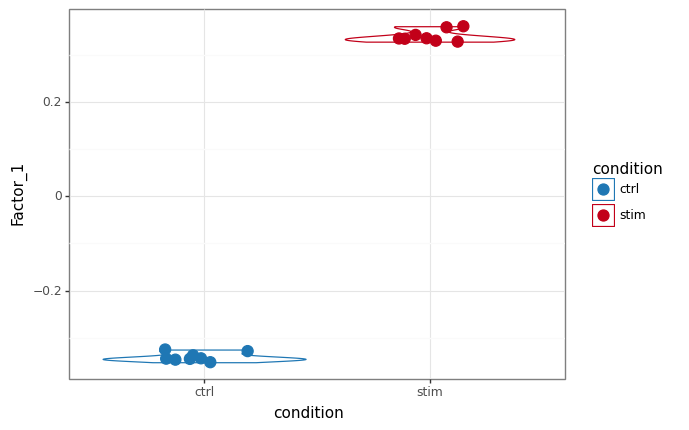

<ggplot: (8736176776045)>

In [17]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw() +
 p9.scale_colour_manual(values=['#1f77b4', '#c20019'])
 )

#### Explore Ligand-Receptor loadings

Now that we have identified a factor that is associated with the sample condition, we can check the ligand-receptor loadings with the highest loadings:

In [21]:
variable_loadings =  li.multi.get_variable_loadings(mdata,
                                                    view_separator=':',
                                                    pair_separator="&",
                                                    variable_separator="^") # get loadings for factor 1
variable_loadings.head()

,ligand_complex,receptor_complex,source,target,Factor_1,Factor_2,Factor_3,Factor_4
478,HLA-DRA,LAG3,DCs,CD8T,1.457874,0.000439,4.274537,-0.000203
997,TNFSF13B,HLA-DPB1,CD14,DCs,1.439642,-0.000135,-0.002458,0.005965
479,HLA-DRB1,LAG3,DCs,CD8T,1.422593,0.000182,4.023089,0.001226
169,CCL8,CCR1,CD14,CD14,1.421600,-0.000730,-0.003431,0.002042
475,HLA-DPB1,LAG3,DCs,CD8T,1.386951,-0.296445,3.743831,0.000605


In [22]:
# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5

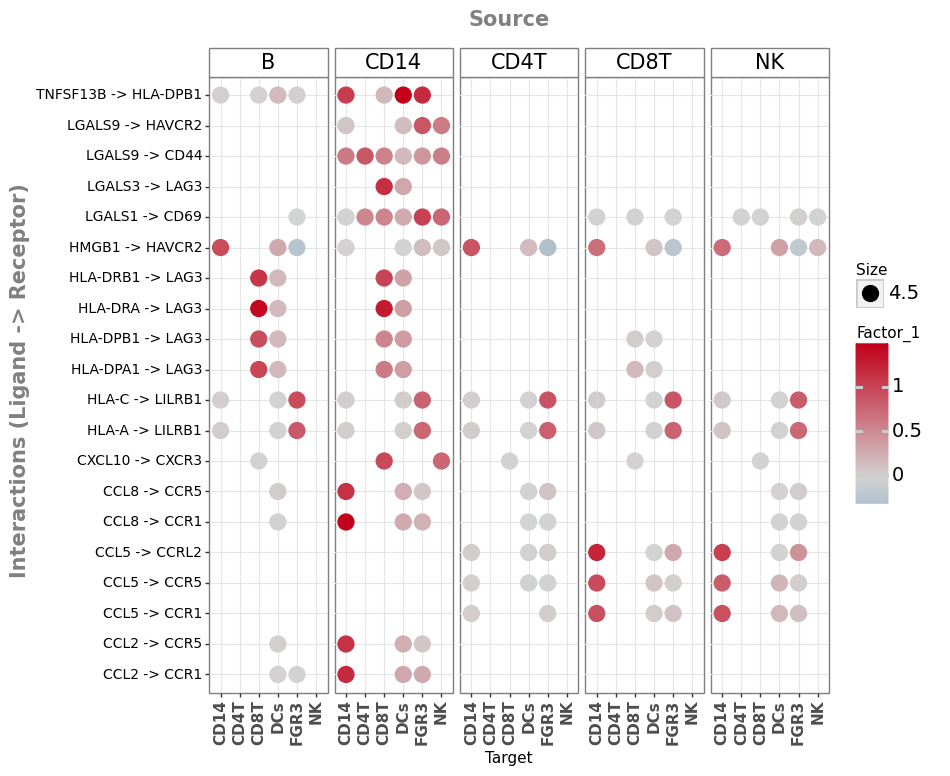

<ggplot: (8736176068368)>

In [28]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour='Factor_1', 
                        orderby='Factor_1',
                        top_n=20,
                        source_labels=['NK', 'B', 'CD4T', 'CD8T', 'CD14'],
                        orderby_ascending=False,
                        size_range=(0.1, 6),
                        figure_size=(8, 8)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019')

Here, we can see that certain interactions from Factor 1 have high positive loadings. These are interactions that are associated with the samples with high factor scores (i.e. the stimulated samples with high scores in Factor 1).

### Explore the model

Finally, we can also explore the MOFA model itself and we will specifically check the variance explained by each pair of cell types.

In [24]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 16
Features: 1714
Groups: group1 (16)
Views: B&CD14 (30), B&CD4T (21), B&CD8T (40), B&DCs (47), B&FGR3 (35), CD14&CD14 (69), CD14&CD4T (29), CD14&CD8T (51), CD14&DCs (81), CD14&FGR3 (77), CD14&NK (32), CD4T&CD14 (27), CD4T&CD8T (29), CD4T&DCs (34), CD4T&FGR3 (32), CD8T&CD14 (34), CD8T&CD8T (37), CD8T&DCs (38), CD8T&FGR3 (38), DCs&CD14 (75), DCs&CD4T (36), DCs&CD8T (58), DCs&DCs (93), DCs&FGR3 (83), DCs&NK (39), FGR3&CD14 (71), FGR3&CD4T (36), FGR3&CD8T (55), FGR3&DCs (85), FGR3&FGR3 (78), FGR3&NK (35), NK&CD14 (36), NK&CD4T (21), NK&CD8T (33), NK&DCs (39), NK&FGR3 (41), NK&NK (19)
Factors: 4
Expectations: W, Z

In [25]:
# get variance explained by view and factor
rsq = model.get_r2()
factor1_rsq = rsq[rsq['Factor']=='Factor1']
# separate view column
factor1_rsq[['source', 'target']] = factor1_rsq['View'].str.split('&', 1, expand=True)

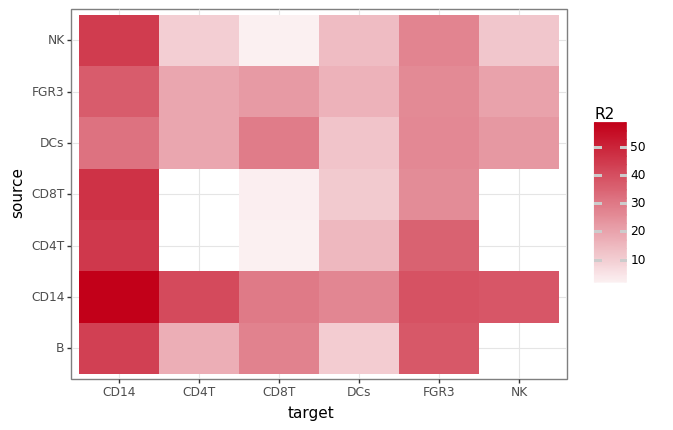

<ggplot: (8736176089353)>

In [26]:
(p9.ggplot(factor1_rsq.reset_index()) + 
 p9.aes(x='target', y='source') + 
 p9.geom_tile(p9.aes(fill='R2')) + 
 p9.scale_fill_gradient2(low='white', high='#c20019') +
 p9.theme_bw() 
 )

Here, we can see that views that include CD14+ Monocytes have the highest variance explained both as source and as target of intercellular communication events. In particular, we see that putative autocrine interactions that occur between CD14+ Monocytes are highly explained by Factor 1.

## Pathway enrichment

Let's also perform an enrichment analysis on the ligand-receptor interactions that are associated with the factor of interest. We will use [decoupler](https://github.com/saezlab/decoupler-py) with pathway genesets from [PROGENy](https://github.com/saezlab/progeny) to look for enrichments across the cell type pairs (views).

In [ ]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [ ]:
# generate ligand-receptor geneset
lr_progeny = li.fun.generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

In [ ]:
lr_loadings =  li.multi.get_variable_loadings(mdata,
                                              0, # get loadings for factor 1
                                              view_separator=':',
                                              )
lr_loadings.set_index('variable', inplace=True)
# pivot views to wide
lr_loadings = lr_loadings.pivot(columns='view', values='loadings')
# replace NaN with 0
lr_loadings.replace(np.nan, 0, inplace=True)
lr_loadings.head()


In [ ]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(), lr_progeny,
                              source="source", target="interaction",
                              use_raw=False, min_n=5)
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'view'})
            )

In [ ]:
## p9 tile plot
(p9.ggplot(estimate) + 
 p9.aes(x='pathway', y='view') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019') +
 p9.theme_bw(base_size=14) +
 p9.theme(figure_size=(8, 8))
)

## Outlook & Further Analysis

This tutorial is just a short introduction of the use of MOFA, we thus refer the users to the available [MOFA](https://biofam.github.io/MOFA2/tutorials.html) & [muon tutorials](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/index.html) for more applications & details.

In [ ]:
model.close()